# ECBM E4040 - Group Project

## Topic: Towards Accurate Binary Convolutional Neural Network
## Group Member: Qichen Hu, Xuechun Zhang, Yingtong Han

In this project, we replicated the results in Towards Accurate Binary Convolutional Neural Network [Lin et al., 2017]. The core idea is to approximate the weights of convolution layer by binarized weights for acceleration purpose. We built the model based on tensorflow 1.13.

In [6]:
from __future__ import division, print_function

# disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
tf.get_logger().setLevel('INFO') # disable warnings
import numpy as np

# import utils functions
from utils_functions import *
import pickle

### Load Data

In [7]:
# load cifar10 data
from tensorflow.keras.datasets import cifar10
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

# scale data to [0,1]
x_train = x_train / 255
x_test = x_test / 255

# train validation split
x_train, x_val = x_train[:-1000], x_train[-1000:]
y_train, y_val = y_train[:-1000], y_train[-1000:]

# check shape
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (49000, 32, 32, 3)
x_val shape: (1000, 32, 32, 3)
y_train shape: (49000, 1)
y_val shape: (1000, 1)


### Build the Graph of Traditional ResNet34

In [10]:
# Creating the full-precision ResNet34 graph without ABC
num_res_blocks_list = [3,4,6,3]
full_precision_graph = tf.Graph()
with full_precision_graph.as_default():
    # Defining inputs
    x = tf.placeholder(dtype=tf.float32)
    x_image = tf.reshape(x, [-1, 32, 32, 3])
    
    # Regularization term
    regularizer = 0
    reg = 0.01
    
    # Create a variable dict to save weights
    full_precision_variables = {}
    
    # Process inputs into the required form
    num_filters_out = 16
    
    with tf.variable_scope('resnet_block', reuse=False):
        # Record layer index
        i = 1
        j = 1
        
        # Convolution Layer 1 before the resnet block
        W_conv1 = weight_variable(shape=([3,3,3,num_filters_out]), name="W_conv1")  #kernel size=3, input channels=3
        b_conv1 = bias_variable(shape=[num_filters_out], name="b_conv1")
        conv1 = (conv2d(x_image, W_conv1) + b_conv1)
        #print(x_image.get_shape(), W_conv1.get_shape())
        bn_conv1 = tf.layers.batch_normalization(conv1, axis=-1, name="bn_conv1")
        h_conv1 = tf.nn.relu(bn_conv1)
        
        full_precision_variables['W_conv1'] = W_conv1
        full_precision_variables['b_conv1'] = b_conv1
        
        regularizer += tf.nn.l2_loss(W_conv1)
        
        # Start resnet block
        i += 1
        
        for stack in range(4):
            for res_block in range(num_res_blocks_list[stack]):
                
                strides_in = [1,1,1,1]
                num_filters_in = num_filters_out
                num_filters_initial_block = num_filters_in
                
                #--------------block layer: y path - first y
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides_in = [1,2,2,1]  # downsample
                    num_filters_out = num_filters_in * 2
                globals()['W_conv' + str(i)] = weight_variable(shape=([3,3,num_filters_in,num_filters_out]), name='W_conv' + str(i))
                globals()['b_conv' + str(i)] = bias_variable(shape=[num_filters_out], name='b_conv' + str(i)) 
                globals()['conv' + str(i)] = (conv2d(globals()['h_conv' + str(i-1)], globals()['W_conv' + str(i)], strides_in) + globals()['b_conv' + str(i)])
                #print(globals()['h_conv' + str(i-1)].get_shape(), globals()['W_conv' + str(i)].get_shape())
                globals()['bn_conv' + str(i)] = tf.layers.batch_normalization(globals()['conv' + str(i)], axis=-1, name='bn_conv' + str(i))
                globals()['h_conv' + str(i)] = tf.nn.relu(globals()['bn_conv' + str(i)])
                full_precision_variables['W_conv' + str(i)] = globals()['W_conv' + str(i)]
                full_precision_variables['b_conv' + str(i)] = globals()['b_conv' + str(i)]
                
                regularizer += tf.nn.l2_loss(globals()['W_conv' + str(i)])
                
                i += 1
                
                num_filters_in = num_filters_out
                
                #--------------block layer: y path - second y
                globals()['W_conv' + str(i)] = weight_variable(shape=([3,3,num_filters_in,num_filters_out]), name='W_conv' + str(i))
                globals()['b_conv' + str(i)] = bias_variable(shape=[num_filters_out], name='b_conv' + str(i)) 
                globals()['conv' + str(i)] = (conv2d(globals()['h_conv' + str(i-1)], globals()['W_conv' + str(i)]) + globals()['b_conv' + str(i)])
                #print(globals()['h_conv' + str(i-1)].get_shape(), globals()['W_conv' + str(i)].get_shape())
                globals()['h_conv' + str(i)] = tf.layers.batch_normalization(globals()['conv' + str(i)], axis=-1, name='bn_conv' + str(i))
                full_precision_variables['W_conv' + str(i)] = globals()['W_conv' + str(i)]
                full_precision_variables['b_conv' + str(i)] = globals()['b_conv' + str(i)]
                
                regularizer += tf.nn.l2_loss(globals()['W_conv' + str(i)])
                
                i += 1
                
                #--------------block layer: x path
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides_in = [1,2,2,1]  # downsample
                    num_filters_in = num_filters_initial_block
                    num_filters_out = num_filters_in * 2 
                    # linear projection residual shortcut connection to match
                    # changed dims
                    globals()['W_conv_cut' + str(j)] = weight_variable(shape=([3,3,num_filters_in,num_filters_out]), name='W_conv_cut' + str(j))
                    globals()['b_conv_cut' + str(j)] = bias_variable(shape=[num_filters_out], name='b_conv_cut' + str(j))
                    globals()['h_conv_cut' + str(j)] = (conv2d(globals()['h_conv' + str(i-3)], globals()['W_conv_cut' + str(j)], strides_in) + globals()['b_conv_cut' + str(j)])
                    #print('x',globals()['h_conv' + str(i-3)].get_shape(), globals()['W_conv_cut' + str(j)].get_shape())
                    full_precision_variables['W_conv_cut' + str(j)] = globals()['W_conv_cut' + str(j)]
                    full_precision_variables['b_conv_cut' + str(j)] = globals()['b_conv_cut' + str(j)]
                    
                    regularizer += tf.nn.l2_loss(globals()['W_conv_cut' + str(j)])
                    
                else:
                    globals()['h_conv_cut' + str(j)] = globals()['h_conv' + str(i-3)]
                
                j += 1
                
                #--------------block: sum and acitvate
                h_add = tf.add(globals()['h_conv_cut' + str(j-1)] , globals()['h_conv' + str(i-1)])
                h_add = tf.nn.relu(h_add)
        
        # Average pooling
        h_pool = tf.nn.max_pool(h_add, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
        
        # Flaten the h_add output
        h_add_flat = tf.reshape(h_pool, shape=(-1, 1*1*128))

        # Dense layer1
        W_fc1 = weight_variable(shape=[1*1*128, 1024], name="W_fc1")
        b_fc1 = bias_variable(shape=[1024], name="b_fc1")
        h_fc1 = tf.nn.relu(tf.matmul(h_add_flat, W_fc1) + b_fc1)
        full_precision_variables['W_fc1'] = W_fc1
        full_precision_variables['b_fc1'] = b_fc1
        
        regularizer += tf.nn.l2_loss(W_fc1)
        
        # Dropout
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        
        # Output layer
        W_fc2 = weight_variable(shape=[1024, 10], name="W_fc2")
        b_fc2 = bias_variable(shape=[10], name="b_fc2")
        full_precision_variables['W_fc2'] = W_fc2
        full_precision_variables['b_fc2'] = b_fc2
        
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        
        regularizer += tf.nn.l2_loss(W_fc2)
        
        # Labels
        y = tf.placeholder(tf.int32, [None])
        y_ = tf.one_hot(y, 10)

        # Defining optimizer and loss
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy + reg*regularizer)
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Initializer
        graph_init = tf.global_variables_initializer()

### Train ResNet34
#### Save the model and weights for initialization of ABC model

In [12]:
# Train
num_epochs = 100
batch_size = 128
num_batch = len(x_train) // batch_size
num_batch_val = len(x_val) // batch_size

full_precision_values = {}  # values fed to the ABC model
cur_model_name = 'ResNet34_full'
pre_trained_model = None

with tf.Session(graph=full_precision_graph) as sess:
    writer = tf.summary.FileWriter("log/{}".format(cur_model_name), sess.graph)
    saver = tf.train.Saver()
    
    sess.run(graph_init)
    
    if pre_trained_model is not None:
        try:
            print("Load the model from: {}".format(pre_trained_model))
            saver.restore(sess, 'model/{}'.format(pre_trained_model))
        except Exception:
            raise ValueError("Load model Failed!")
    
    for epoch in range(num_epochs):
        for iteration in range(1, num_batch + 1):
            X_batch, y_batch = x_train[(iteration-1)*batch_size:iteration*batch_size], y_train[(iteration-1)*batch_size:iteration*batch_size]
            y_batch = y_batch.reshape(batch_size)
            
            # Run operation and calculate loss
            _, acc_train, loss_train = sess.run([train_step, accuracy, cross_entropy],
                                                feed_dict={x: X_batch, y: y_batch, keep_prob: 0.5})
            
            print("\rIteration: {}/{} ({:.1f}%) Train Acc: {:.4f}%".format(iteration,
                                                                           num_batch,
                                                                           iteration*100/num_batch,
                                                                           acc_train*100),
                  end="")
        
        # At the end of each epoch, measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, num_batch_val + 1):
            X_batch, y_batch = x_val[(iteration-1)*batch_size:iteration*batch_size], y_val[(iteration-1)*batch_size:iteration*batch_size]
            y_batch = y_batch.reshape(batch_size)
            acc_val, loss_val = sess.run([accuracy, cross_entropy], feed_dict={x: X_batch, y: y_batch, keep_prob: 1})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(iteration, num_batch_val,iteration * 100/num_batch_val),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}".format(epoch + 1, acc_val * 100, loss_val))
    
    # Save model to file
    saver.save(sess, 'model/{}'.format(cur_model_name))
    
    # On completion of training, save the variables to be fed to ABC model
    for var_name in full_precision_variables:
        full_precision_values[var_name] = sess.run(full_precision_variables[var_name])
    
    # Save weights to file
    f = open("Weights/"+cur_model_name+".pkl", "wb")
    pickle.dump(full_precision_values, f)
    f.close()

Epoch: 1  Val accuracy: 10.2679%  Loss: 4.186936
Epoch: 2  Val accuracy: 13.8393%  Loss: 2.320942
Epoch: 3  Val accuracy: 15.8482%  Loss: 2.259161
Epoch: 4  Val accuracy: 17.0759%  Loss: 2.199602
Epoch: 5  Val accuracy: 19.0848%  Loss: 2.119938
Epoch: 6  Val accuracy: 23.5491%  Loss: 2.070393
Epoch: 7  Val accuracy: 21.3170%  Loss: 2.034542
Epoch: 8  Val accuracy: 24.6652%  Loss: 2.000831
Epoch: 9  Val accuracy: 24.1071%  Loss: 1.987054
Epoch: 10  Val accuracy: 26.7857%  Loss: 1.938736
Epoch: 11  Val accuracy: 29.6875%  Loss: 1.894928
Epoch: 12  Val accuracy: 27.6786%  Loss: 1.882040
Epoch: 13  Val accuracy: 31.0268%  Loss: 1.879210
Epoch: 14  Val accuracy: 30.2455%  Loss: 1.874845
Epoch: 15  Val accuracy: 35.2679%  Loss: 1.801635
Epoch: 16  Val accuracy: 34.7098%  Loss: 1.785804
Epoch: 17  Val accuracy: 35.3795%  Loss: 1.763273
Epoch: 18  Val accuracy: 36.4955%  Loss: 1.740854
Epoch: 19  Val accuracy: 38.5045%  Loss: 1.702831
Epoch: 20  Val accuracy: 38.9509%  Loss: 1.685941
Epoch: 21

### Build the Graph of ResNet34 with ABC

In [15]:
# Creating the ResNet34 graph with ABC, M = 5, N = 5
num_res_blocks_list = [3,4,6,3]
ABC_graph = tf.Graph()
with ABC_graph.as_default():
    # Defining inputs
    x = tf.placeholder(dtype=tf.float32)
    x_image = tf.reshape(x, [-1, 32, 32, 3])
    
    # Store alpha training and alphas
    alpha_training_list = []
    alphas_list = []
    
    # Set ABC hyperparameters
    M = 5
    N = 5
    s_min, s_max = -0.2, 0.2
    s_gap = (s_max - s_min) / (N-1)
    shift_para = tf.Variable(tf.constant(np.arange(s_min, s_max+1e-4, s_gap).tolist(), dtype=tf.float32, name="shift_para"))
    betas = tf.Variable(tf.constant(1/N, shape=(N,1)), dtype=tf.float32, name="betas")
    
    # Create a variable dict to save weights
    ABC_variables = {}
    
    # Process inputs into the required form
    num_filters_out = 16
    
    with tf.variable_scope('resnet_block', reuse=False):
        # Record layer index
        i = 1
        j = 1
        
        # Convolution Layer 1 before the resnet block
        W_conv1 = tf.Variable(full_precision_values["W_conv1"], name="W_conv1")
        b_conv1 = tf.Variable(full_precision_values["b_conv1"], name="b_conv1")
        # ABC
        alphas1 = tf.Variable(tf.random_normal(shape=(M,1), mean=1.0, stddev=0.1), dtype=tf.float32, name="alphas1")
        binary_weights1 = calculate_binary_weights(W_conv1, M)
        alpha_loss1, alpha_training1 = calculate_alphas(W_conv1, binary_weights1, alphas1, M)
        h_conv1 = ABC_layer(x_image, binary_weights1, alphas1, shift_para, betas, M, N, b_conv1)
        # Save alpha training and alphas
        alpha_training_list.append(alpha_training1)
        alphas_list.append(alphas1)
        
        bn_conv1 = tf.layers.batch_normalization(h_conv1, axis=-1, name="bn_conv1")
        h_conv1 = tf.nn.relu(bn_conv1)
        
        ABC_variables['W_conv1'] = W_conv1
        ABC_variables['b_conv1'] = b_conv1
        
        # Start resnet block
        i += 1
        
        for stack in range(4):
            for res_block in range(num_res_blocks_list[stack]):
                
                strides_in = 1
                num_filters_in = num_filters_out
                num_filters_initial_block = num_filters_in
                
                #--------------block layer: y path - first y
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides_in = 2  # downsample
                    num_filters_out = num_filters_in * 2
                globals()['W_conv' + str(i)] = tf.Variable(full_precision_values['W_conv' + str(i)], name='W_conv' + str(i))
                globals()['b_conv' + str(i)] = tf.Variable(full_precision_values['b_conv' + str(i)], name='b_conv' + str(i))
                # ABC
                globals()['alphas' + str(i)] = tf.Variable(tf.random_normal(shape=(M,1), mean=1.0, stddev=0.1), dtype=tf.float32, name='alphas' + str(i))
                globals()['binary_weights' + str(i)] = calculate_binary_weights(globals()['W_conv' + str(i)], M)
                globals()['alpha_loss' + str(i)], globals()['alpha_training' + str(i)] = calculate_alphas(globals()['W_conv' + str(i)], globals()['binary_weights' + str(i)], globals()['alphas' + str(i)], M)
                globals()['conv' + str(i)] = ABC_layer(globals()['h_conv' + str(i-1)], globals()['binary_weights' + str(i)], globals()['alphas' + str(i)], shift_para, betas, M, N, globals()['b_conv' + str(i)], strides_in)
                # save alpha training and alphas
                alpha_training_list.append(globals()['alpha_training' + str(i)])
                alphas_list.append(globals()['alphas' + str(i)])
                
                globals()['bn_conv' + str(i)] = tf.layers.batch_normalization(globals()['conv' + str(i)], axis=-1, name='bn_conv' + str(i))
                globals()['h_conv' + str(i)] = tf.nn.relu(globals()['bn_conv' + str(i)])
                
                ABC_variables['W_conv' + str(i)] = globals()['W_conv' + str(i)]
                ABC_variables['b_conv' + str(i)] = globals()['b_conv' + str(i)]
                
                i += 1
                
                num_filters_in = num_filters_out
                
                #--------------block layer: y path - second y
                globals()['W_conv' + str(i)] = tf.Variable(full_precision_values['W_conv' + str(i)], name='W_conv' + str(i))
                globals()['b_conv' + str(i)] = tf.Variable(full_precision_values['b_conv' + str(i)], name='b_conv' + str(i))
                # ABC
                globals()['alphas' + str(i)] = tf.Variable(tf.random_normal(shape=(M,1), mean=1.0, stddev=0.1), dtype=tf.float32, name='alphas' + str(i))
                globals()['binary_weights' + str(i)] = calculate_binary_weights(globals()['W_conv' + str(i)], M)
                globals()['alpha_loss' + str(i)], globals()['alpha_training' + str(i)] = calculate_alphas(globals()['W_conv' + str(i)], globals()['binary_weights' + str(i)], globals()['alphas' + str(i)], M)
                globals()['conv' + str(i)] = ABC_layer(globals()['h_conv' + str(i-1)], globals()['binary_weights' + str(i)], globals()['alphas' + str(i)], shift_para, betas, M, N, globals()['b_conv' + str(i)])
                # save alpha training and alphas
                alpha_training_list.append(globals()['alpha_training' + str(i)])
                alphas_list.append(globals()['alphas' + str(i)])
                
                globals()['h_conv' + str(i)] = tf.layers.batch_normalization(globals()['conv' + str(i)], axis=-1, name='bn_conv' + str(i))
                
                ABC_variables['W_conv' + str(i)] = globals()['W_conv' + str(i)]
                ABC_variables['b_conv' + str(i)] = globals()['b_conv' + str(i)]
                
                i += 1
                
                #--------------block layer: x path
                if stack > 0 and res_block == 0:  # first layer but not first stack
                    strides_in = 2  # downsample
                    num_filters_in = num_filters_initial_block
                    num_filters_out = num_filters_in * 2 
                    # linear projection residual shortcut connection to match
                    # changed dims
                    globals()['W_conv_cut' + str(j)] = tf.Variable(full_precision_values['W_conv_cut' + str(j)], name='W_conv_cut' + str(j))
                    globals()['b_conv_cut' + str(j)] = tf.Variable(full_precision_values['b_conv_cut' + str(j)], name='b_conv_cut' + str(j))
                    # ABC
                    globals()['alphas' + str(j*100+i)] = tf.Variable(tf.random_normal(shape=(M,1), mean=1.0, stddev=0.1), dtype=tf.float32, name='alphas' + str(j*100+i))
                    globals()['binary_weights' + str(j*100+i)] = calculate_binary_weights(globals()['W_conv_cut' + str(j)], M)
                    globals()['alpha_loss' + str(j*100+i)], globals()['alpha_training' + str(j*100+i)] = calculate_alphas(globals()['W_conv_cut' + str(j)], globals()['binary_weights' + str(j*100+i)], globals()['alphas' + str(j*100+i)], M)
                    globals()['h_conv_cut' + str(j)] = ABC_layer(globals()['h_conv' + str(i-3)], globals()['binary_weights' + str(j*100+i)], globals()['alphas' + str(j*100+i)], shift_para, betas, M, N, globals()['b_conv_cut' + str(j)], strides_in)
                    # save alpha training and alphas
                    alpha_training_list.append(globals()['alpha_training' + str(j*100+i)])
                    alphas_list.append(globals()['alphas' + str(j*100+i)])
                    
                    ABC_variables['W_conv_cut' + str(j)] = globals()['W_conv_cut' + str(j)]
                    ABC_variables['b_conv_cut' + str(j)] = globals()['b_conv_cut' + str(j)]
                    
                else:
                    globals()['h_conv_cut' + str(j)] = globals()['h_conv' + str(i-3)]
                
                j += 1
                
                #--------------block: sum and acitvate
                h_add = tf.add(globals()['h_conv_cut' + str(j-1)] , globals()['h_conv' + str(i-1)])
                h_add = tf.nn.relu(h_add)
        
        # Average pooling
        h_pool = tf.nn.max_pool(h_add, ksize=[1,4,4,1], strides=[1,4,4,1], padding="SAME")
        
        # Flaten the h_add output
        h_add_flat = tf.reshape(h_pool, shape=(-1, 1*1*128))
        
        # Dense layer1
        W_fc1 = tf.Variable(full_precision_values["W_fc1"], name="W_fc1")
        b_fc1 = tf.Variable(full_precision_values["b_fc1"], name="b_fc1")
        h_fc1 = tf.nn.relu(tf.matmul(h_add_flat, W_fc1) + b_fc1)
        ABC_variables['W_fc1'] = W_fc1
        ABC_variables['b_fc1'] = b_fc1
        
        # Dropout
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        
        # Output layer
        W_fc2 = tf.Variable(full_precision_values["W_fc2"], name="W_fc2")
        b_fc2 = tf.Variable(full_precision_values["b_fc2"], name="b_fc2")
        ABC_variables['W_fc2'] = W_fc2
        ABC_variables['b_fc2'] = b_fc2
        
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        
        # Labels
        y = tf.placeholder(tf.int32, [None])
        y_ = tf.one_hot(y, 10)
        
        # Defining optimizer and loss
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Initializer
        graph_init = tf.global_variables_initializer()
        alphas_init = tf.variables_initializer(alphas_list)

### Train ResNet34 with ABC
#### Save the model and weights

In [16]:
# Train
num_epochs = 20
batch_size = 128
num_batch = len(x_train) // batch_size
num_batch_val = len(x_val) // batch_size
num_alpha_epochs = 200

ABC_values = {}  # values fed to the ABC model
cur_model_name = 'ResNet34_ABC_5_5'
pre_trained_model = None

loss_history=[]

with tf.Session(graph=ABC_graph) as sess:
    writer = tf.summary.FileWriter("log/{}".format(cur_model_name), sess.graph)
    saver = tf.train.Saver()
    
    sess.run(graph_init)
    
    if pre_trained_model is not None:
        try:
            print("Load the model from: {}".format(pre_trained_model))
            saver.restore(sess, 'model/{}'.format(pre_trained_model))
        except Exception:
            raise ValueError("Load model Failed!")
    
    for epoch in range(num_epochs):
        for iteration in range(1, num_batch + 1):
            X_batch, y_batch = x_train[(iteration-1)*batch_size:iteration*batch_size], y_train[(iteration-1)*batch_size:iteration*batch_size]
            y_batch = y_batch.reshape(batch_size)
            
            # Training alphas
            sess.run(alphas_init)
            for alpha_train in alpha_training_list:
                for alpha_epoch in range(num_alpha_epochs):
                    sess.run(alpha_train)
            
            # Run operation and calculate loss
            _, acc_train, loss_train = sess.run([train_step, accuracy, cross_entropy],
                                                feed_dict={x: X_batch, y: y_batch, keep_prob: 1})
            loss_history.append(loss_train)
            
            
            print("\rIteration: {}/{} ({:.1f}%) Train Acc: {:.4f}%".format(iteration,
                                                                           num_batch,
                                                                           iteration*100/num_batch,
                                                                           acc_train*100),
                  end="")
        
        # At the end of each epoch, measure the validation loss and accuracy:
        # Training alphas
        sess.run(alphas_init)
        for alpha_train in alpha_training_list:
            for alpha_epoch in range(num_alpha_epochs):
                sess.run(alpha_train)
        
        loss_vals = []
        acc_vals = []
        for iteration in range(1, num_batch_val + 1):
            X_batch, y_batch = x_val[(iteration-1)*batch_size:iteration*batch_size], y_val[(iteration-1)*batch_size:iteration*batch_size]
            y_batch = y_batch.reshape(batch_size)
            acc_val, loss_val = sess.run([accuracy, cross_entropy], feed_dict={x: X_batch, y: y_batch, keep_prob: 1})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(iteration, num_batch_val,iteration * 100/num_batch_val),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}".format(epoch + 1, acc_val * 100, loss_val))
    
    # Save model to file
    saver.save(sess, 'model/{}'.format(cur_model_name))
    
    # On completion of training, save the variables to be fed to ABC model
    for var_name in ABC_variables:
        ABC_values[var_name] = sess.run(ABC_variables[var_name])
    
    # Save weights to file
    f = open("Weights/"+cur_model_name+".pkl", "wb")
    pickle.dump(ABC_values, f)
    f.close()
    

Epoch: 1  Val accuracy: 10.0446%  Loss: 3.016400
Epoch: 2  Val accuracy: 12.9464%  Loss: 2.433650
Epoch: 3  Val accuracy: 12.8348%  Loss: 2.368501
Epoch: 4  Val accuracy: 16.0714%  Loss: 2.307099
Epoch: 5  Val accuracy: 10.4911%  Loss: 2.444845
Epoch: 6  Val accuracy: 12.8348%  Loss: 2.309932
Epoch: 7  Val accuracy: 15.0670%  Loss: 2.271864
Epoch: 8  Val accuracy: 17.9688%  Loss: 2.260310
Epoch: 9  Val accuracy: 9.5982%  Loss: 2.346605
Epoch: 10  Val accuracy: 12.1652%  Loss: 2.346973
Epoch: 11  Val accuracy: 11.4955%  Loss: 2.345157
Epoch: 12  Val accuracy: 14.6205%  Loss: 2.266306
Epoch: 13  Val accuracy: 12.7232%  Loss: 2.291463
Epoch: 14  Val accuracy: 16.1830%  Loss: 2.238191
Epoch: 15  Val accuracy: 15.0670%  Loss: 2.238681
Epoch: 16  Val accuracy: 15.2902%  Loss: 2.275445
Epoch: 17  Val accuracy: 11.2723%  Loss: 2.316804
Epoch: 18  Val accuracy: 13.8393%  Loss: 2.245106
Epoch: 19  Val accuracy: 15.7366%  Loss: 2.265240
Epoch: 20  Val accuracy: 14.8438%  Loss: 2.233760


### Loss Plot

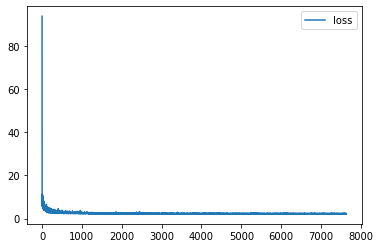

In [21]:
import matplotlib.pyplot as plt
plt.plot(loss_history, label="loss")
plt.legend()
plt.show()